# Data analysis, Network projection and cluster identification
## Imports

In [60]:
import json
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from numpy import linalg as LA

import pandas as pd

import networkx as nx
import community

from tqdm import tqdm
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

## Data preparation
### Loading of the data

In [6]:
# Download names to make it more friendly
json_file_path_1 = '../data/all_coins_by_mc_1.json'
json_file_path_2 = '../data/all_coins_by_mc_2.json'

# Open the JSON file and load its contents
with open(json_file_path_1, 'r') as file:
    data = json.load(file)

with open(json_file_path_2, 'r') as file:
    data = data + json.load(file)
# Now, 'data' contains the contents of the JSON file as a Python object (dictionary, list, etc.)
names_list = [stock["name"] for stock in data]

### Load price data and preprocessing

In [7]:
data = pd.read_csv("../data/processed/prices.csv", parse_dates=['date'])
data.rename(columns={data.columns[0]: 'date'}, inplace=True)
data.set_index("date", inplace=True)
data.columns = names_list
data = data.loc['2021-01-01':'2022-12-31'] # Filter
data = data.dropna(axis=1, how='all') # Drop all columns that contains only null value
data = data.dropna(axis=1, thresh=0.95*len(data.index)) # Drop columns that contains more than 25% of null value
data = data.ffill() # ffill null values
data.dropna(inplace=True)

### Compute and normalize Hourly log-return

In [8]:
hourly_returns_pct = data.pct_change()
hourly_returns_pct = hourly_returns_pct.iloc[1:]
hourly_returns_pct.to_csv("../data/processed/hourly_return.csv")
hourly_log_returns = np.log(hourly_returns_pct + 1)

In [83]:
scaler = StandardScaler()
hourly_log_returns = pd.DataFrame(scaler.fit_transform(hourly_log_returns), columns=hourly_log_returns.columns, index=hourly_log_returns.index)
hourly_log_returns.to_csv("../data/processed/normalized_log_ret.csv")

## Eigenvalues of correlation matrix analysis

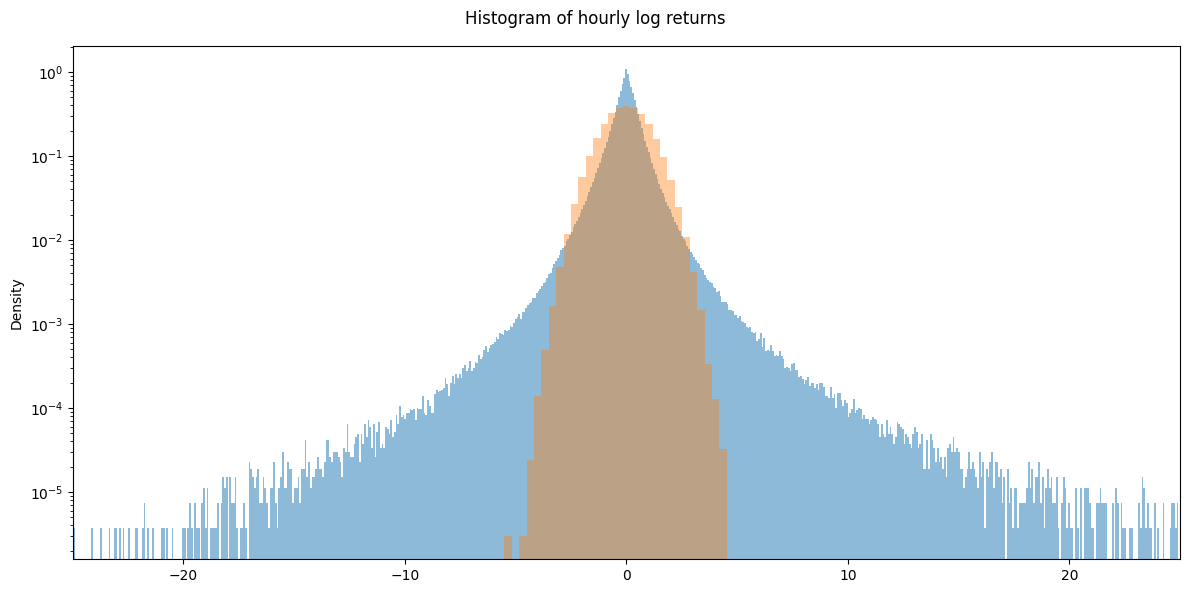

In [87]:
plt.subplots(figsize = (12,6))
sns.histplot(hourly_log_returns.values.flatten(), stat='density', bins=2000, alpha=0.5, edgecolor='None')
sns.histplot(np.random.normal(0,1,1000000), stat='density', alpha=0.4, bins = 30, edgecolor='None')
plt.suptitle("Histogram of hourly log returns")
plt.yscale('log')
plt.xlim(-25, 25)
plt.tight_layout()
plt.show()

In [13]:
# Function to permute each column independently
def permute_columns(df):
    permuted_df = df.apply(np.random.permutation, axis=0)
    return permuted_df

In [14]:
def P0(lambdas,q, sigma):
    lambda_plus = sigma**2*(1+np.sqrt(q))**2
    lambda_minus = sigma**2*(1-np.sqrt(q))**2
    vals = 1/(q*2*np.pi*sigma**2*lambdas)*np.sqrt((lambda_plus-lambdas)*(lambdas-lambda_minus))
    return vals

In [39]:
## Generate random matrix
N=1000
T=7000
R=np.random.normal(0,1,N*T).reshape((N,T)) # Generate N*T iid standard normal random variables
print(f"Shape of random matrix: {R.shape}")

## Compute empirical correlation matrix
C=np.corrcoef(R) # Correlation matrix
print(f"Correlation matrix shape: {C.shape}")

## Compute eigenvalues and eigenvectors of the correlation matrix
lambdas_e, V_e = LA.eig(C)

q=N/T
lambdas=np.linspace((1.-np.sqrt(q))**2,(1.+np.sqrt(q))**2,200) 
P0s=P0(lambdas, q, 1)

Shape of random matrix: (1000, 7000)
Correlation matrix shape: (1000, 1000)


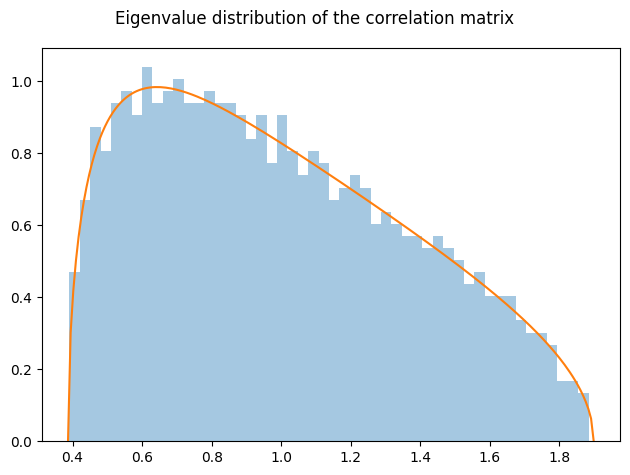

In [49]:
%%capture --no-display
sns.distplot(lambdas_e[1:],kde=False, norm_hist=True, bins=50)  # no Kernel Density Estimation
plt.plot(lambdas,P0s)
plt.suptitle("Eigenvalue distribution of the correlation matrix")
plt.tight_layout()
plt.show()

In [33]:
lambdas_e_list_720 = []
for i in range(1):#range(100, 11000, 100):
    permuted_df = hourly_log_returns[i:720+i]
    (T_720,N_720) = permuted_df.shape
    C = permuted_df.corr().to_numpy()
    lambdas_e, V_e = LA.eig(C)
    lambdas_e_list_720.append(lambdas_e)
lambdas_e_list_720 = np.array(lambdas_e_list_720).flatten()

In [34]:
lambdas_e_list_perm = []
for i in range(100):
    permuted_df = permute_columns(hourly_log_returns)
    (T_perm,N_perm) = permuted_df.shape
    C = permuted_df.corr().to_numpy()
    lambdas_e, V_e = LA.eig(C)
    lambdas_e_list_perm.append(lambdas_e)
lambdas_e_list_perm = np.array(lambdas_e_list_perm).flatten()

In [35]:
(T_all,N_all) = hourly_log_returns.shape
C = hourly_log_returns.corr().to_numpy()
lambdas_e_all, V_e = LA.eig(C)

In [36]:
q_all=N_all/T_all
sigma = 1
lambdas_all=np.linspace(sigma**2*(1.-np.sqrt(q_all))**2,sigma**2*(1.+np.sqrt(q_all))**2,200)
P0s_all=P0(lambdas_all, q_all, sigma=sigma)

q_perm=N_perm/T_perm
sigma = 1
lambdas_perm=np.linspace(sigma**2*(1.-np.sqrt(q_perm))**2,sigma**2*(1.+np.sqrt(q_perm))**2,200)
P0s_perm=P0(lambdas_perm, q_perm, sigma=sigma)

q_720=N_720/T_720
sigma = 1
lambdas_720=np.linspace(sigma**2*(1.-np.sqrt(q_720))**2,sigma**2*(1.+np.sqrt(q_720))**2,200)
P0s_720=P0(lambdas_720,q_720, sigma=sigma)

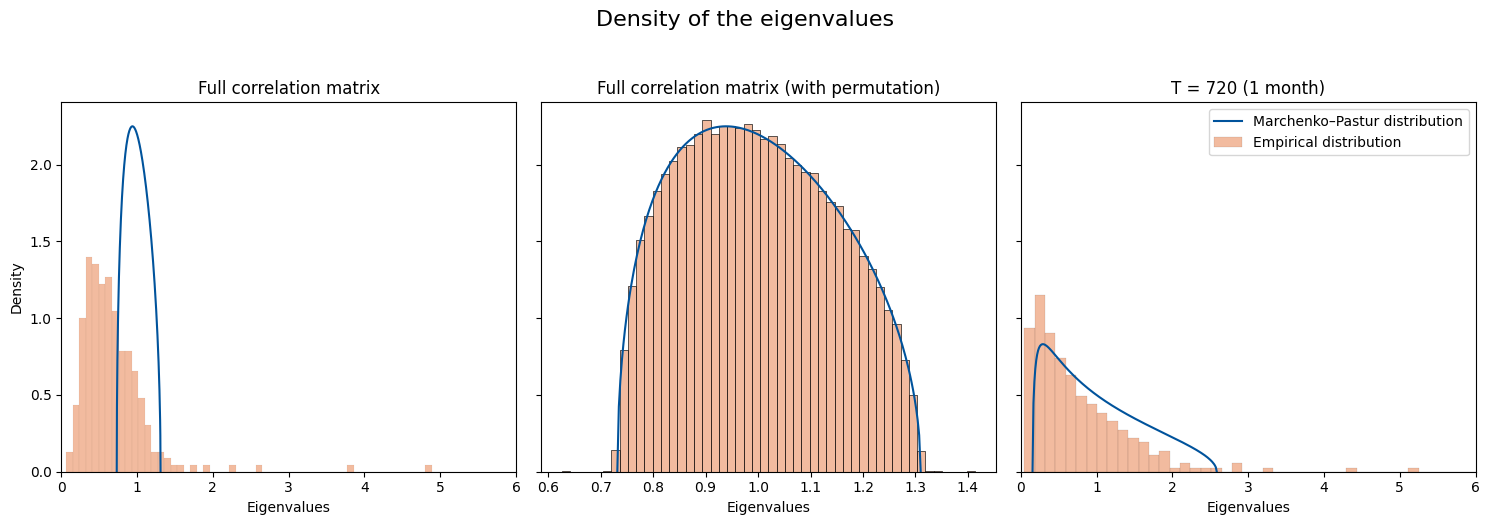

In [51]:
%%capture --no-display
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

sns.histplot(lambdas_e_all, ax = axs[0], stat='density', bins=1000, color='#EEA47F', label='Empirical distribution')  # no Kernel Density Estimation
axs[0].plot(lambdas_all, P0s_all, color='#00539C', label='Marcenko-Pastur distribution')
axs[0].set_xlim(0,6)
axs[0].set_title("Full correlation matrix")
axs[0].set_xlabel("Eigenvalues")

plt.legend()



sns.histplot(lambdas_e_list_perm, ax = axs[1], stat='density', bins=50, color='#EEA47F', label='Empirical distribution')  # no Kernel Density Estimation
axs[1].plot(lambdas_perm, P0s_perm, color='#00539C', label='Marcenko-Pastur distribution')
axs[1].set_title("Full correlation matrix (with permutation)")
axs[1].set_xlabel("Eigenvalues")




sns.histplot(lambdas_e_list_720, ax = axs[2], stat='density', bins=400, color='#EEA47F', label='Empirical distribution')  # no Kernel Density Estimation
axs[2].plot(lambdas_720, P0s_720, color='#00539C', label='Marchenko–Pastur distribution')
axs[2].set_xlim(0, 6)
axs[2].set_title("T = 720 (1 month)")
axs[2].set_xlabel("Eigenvalues")


fig.suptitle('Density of the eigenvalues', fontsize=16, y = 1.04)


plt.legend()
plt.tight_layout()
plt.show()

## Network creation methods

### Filtering based on RMT

In [52]:
def compute_C_minus_C0(lambdas, v, lambda_plus, removeMarketMode=False):
    N=len(lambdas)
    C_clean=np.zeros((N, N))

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]

    v_m=np.matrix(v)

    # note that the eivenvalues are sorted
    for i in range(1*removeMarketMode,N):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)
    return C_clean

### From C (as in class)

In [53]:
def baseline_network(R):# R is a matrix of return
    """Baseline network

    Args:
        R: Return matrix

    Returns:
        NetworkX graph
    """
    
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2
    C=R.corr()
    lambdas, v = LA.eigh(C)
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    C_s = np.abs(C_s)

    return nx.from_numpy_array(C_s)


### Minimum Spanning Tree

In [54]:
def mst_network(R):
    """Minimum spanning tree network

    Args:
        R: Return matrix

    Returns:
        NetworkX graph
    """
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2
    C=R.corr()
    lambdas, v = LA.eigh(C)
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    
    # Compute distance matrix
    D = np.sqrt(2*(1-C_s))
    # Compute MST
    G = nx.from_numpy_array(D)
    return nx.minimum_spanning_tree(G)

### Threshold network

In [56]:
def threshold_network(R, threshold=0.05):
    """Threshold network

    Args:
        R: Matrix of returns
        threshold (float, optional): Cutting threshold . Defaults to 0.05.

    Returns:
        NetworkX graph
    """
    N = R.shape[1]
    T = R.shape[0]
    
    # Compute lambda_plus and correlation matrix
    q = N * 1. / T
    lambda_plus = (1. + np.sqrt(q)) ** 2
    C = R.corr()
    lambdas, v = LA.eigh(C)
    C_s = np.array(compute_C_minus_C0(lambdas, v, lambda_plus))

    # Determine the threshold value for each column
    np.fill_diagonal(C_s, 0)
    threshold_values = np.percentile(C_s, threshold * 100, axis=0)
    threshold_values[threshold_values < 0] = 0

    # Set values below the threshold to 0
    C_s[C_s < threshold_values] = 0

    # Compute graph
    G = nx.from_numpy_array(C_s)
    return G

### Planar Maximally Filtered Graph

In [57]:
def sort_graph_edges(G):
    """Sort graph edges by weight

    Args:
        G : NetworkX graph

    Returns:
        Sorted list of edges
    """
    sorted_edges = []
    for source, dest, data in sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True):
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data['weight']})
        
    return sorted_edges

def compute_PMFG(sorted_edges, nb_nodes):
    """Compute PMFG

    Args:
        sorted_edges: List of sorted edges
        nb_nodes: Number of nodes

    Returns:
       NetworkX graph (PMFG)
    """
    PMFG = nx.Graph()
    for edge in sorted_edges:
        PMFG.add_edge(edge['source'], edge['dest'])
        if not nx.is_planar(PMFG) or edge['source'] == edge['dest']:
            PMFG.remove_edge(edge['source'], edge['dest'])
            
        if len(PMFG.edges()) == 3*(nb_nodes-2):
            break
    
    return PMFG


def pmfg_network(R):
    """PLANAR MAXIMUM FILTERED GRAPH (PMFG) network

    Args:
        R : Matrix of returns

    Returns:
        NetworkX graph
    """
    N = R.shape[1]
    T = R.shape[0]
    
    # Compute lambda_plus and correlation matrix
    q = N * 1. / T
    lambda_plus = (1. + np.sqrt(q)) ** 2
    C = R.corr()
    lambdas, v = LA.eigh(C)
    C = compute_C_minus_C0(lambdas, v, lambda_plus)
    
    # Compute graph
    G = nx.from_numpy_array(C)
    
    sorted_edges = sort_graph_edges(G)
    
    return compute_PMFG(sorted_edges, N)

## Visualization of the different network

4it [00:00,  6.04it/s]


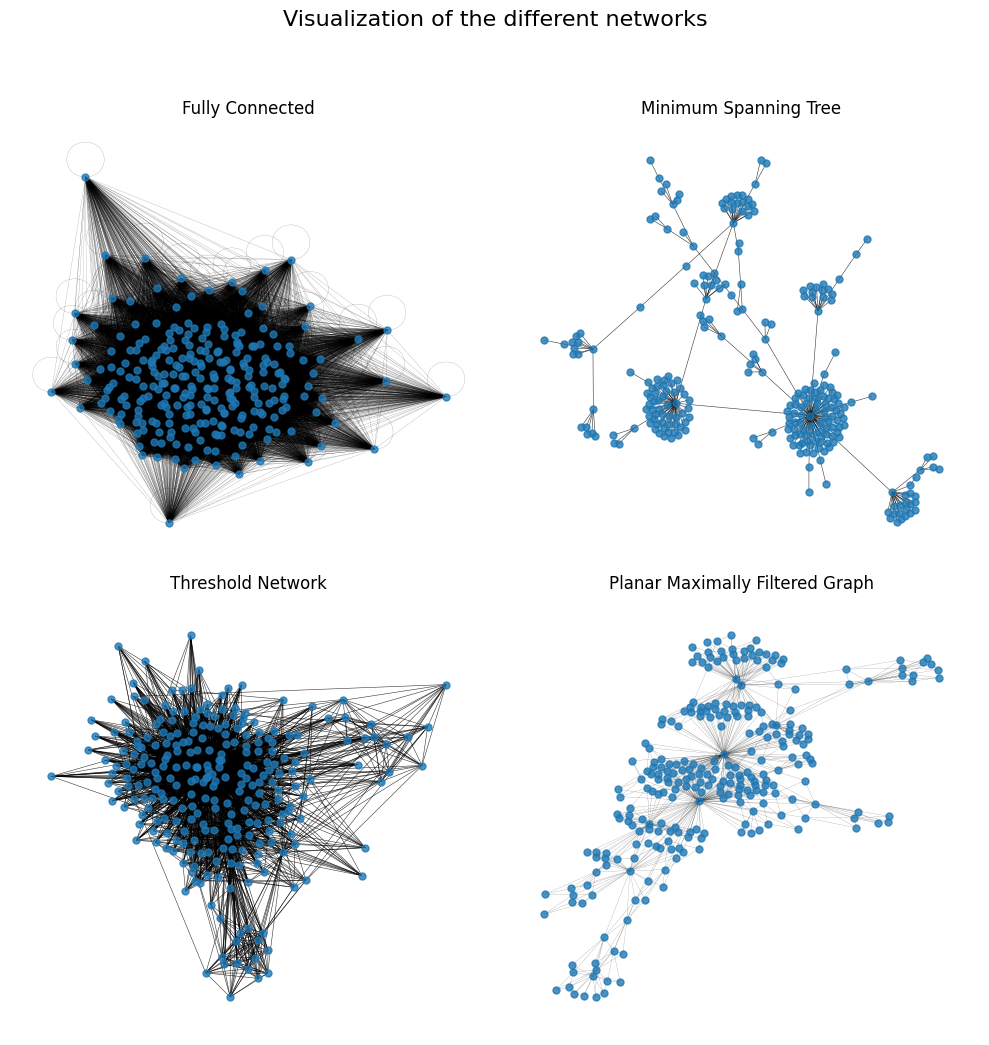

In [58]:
R = pd.read_csv("../data/processed/normalized_log_ret.csv").set_index('date')
Gs = [baseline_network(R), mst_network(R), threshold_network(R, threshold=0.95), pmfg_network(R)]

fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, ax in tqdm(enumerate(axs.flatten())):
    if i == 0 or i == 3:
        width = 0.1
    else:
        width = 0.4
        
    nx.draw(Gs[i], node_size=25, width=width, ax=ax, alpha=0.8, pos=nx.spring_layout(Gs[i], seed=42))
    ax.set_title(['Fully Connected', 'Minimum Spanning Tree', 'Threshold Network', 'Planar Maximally Filtered Graph'][i])

plt.suptitle("Visualization of the different networks", fontsize=16, y = 1.04)
plt.tight_layout()
plt.show()

## Clusters computation

In [59]:
def rename_asset(R, partition):
    """Rename assets

    Args:
        R: Return matrix
        partition: Partition dictionary

    Returns:
        Dictionary of clusters
    """
    dict_cluster = {}
    all_names = list(R.columns)
    for i, name in enumerate(all_names):
        cluster = partition.get(i, None)
        if cluster is not None:
            dict_cluster[name]=partition[i]
        
    return dict_cluster

def louvain_clustering(G, resolution):
    """Louvain clustering

    Args:
        G: NetworkX graph
        resolution (_type_): Resolution parameter

    Returns:
        Clustering dictionary
    """
    return  community.community_louvain.best_partition(G, resolution=resolution)

def clustering(R: pd.DataFrame, period: int=720, interval: int = 24, method:str='baseline') -> dict:
    """Compute the clusters in a rolling window manner for the return matrix R.

    Args:
        R (pd.Dataframe): Normalized log-return matrix
        period (int, optional): time period_. Defaults to 30 days (720 hours).
        interval (int, optional): time interval. Defaults to 1 day (24 hours).
        method (str, optional): Clustering method. Defaults to 'baseline'. Can be 'baseline', 'mst' 'threshold', 'pmf'.
    """
    cluster_dict = {}
    resolution = 1
    for t0 in tqdm(range(0, len(R.index)-period, interval)):
        R_tmp = R.iloc[t0:t0+period]
        if method == 'baseline':
            G = baseline_network(R_tmp)
            resolution = 1.02
        elif method == 'mst':
            G = mst_network(R_tmp)
            resolution = 0.9
        elif method == 'threshold':
            G = threshold_network(R_tmp)
            resolution = 1.025
        elif method == 'pmfg':
            G = pmfg_network(R_tmp)
            resolution = 1.03
        else:
            raise ValueError("Method not recognized")
            
        
        cluster_dict[(t0, t0+period)] = rename_asset(R_tmp, louvain_clustering(G, resolution))
            
    return cluster_dict

In [66]:
clusters_dict = dict()

for method in ['baseline', 'mst', 'thresh', 'pmfg']:
    path = Path("../data/processed/clusters_{}_720_24.pkl".format(method))
    if path.exists():
        with open(path, 'rb') as f:
            clusters_dict[method] = pickle.load(f)
    else:
        df = pd.read_csv("../data/processed/normalized_log_ret.csv")
        cluster = clustering(df.set_index('date'), period=720, interval=24, method=method)
        clusters_dict[method] = cluster
        with open(f"../data/processed/clusters_{method}_720_24.pkl", "wb") as f:
            pickle.dump(cluster, f)

In [81]:
# First cluster of first period for each method
for method in ['baseline', 'mst', 'thresh', 'pmfg']:
    print("***** {} *****".format(method))
    print([k for k,v in clusters_dict[method][(0, 720)].items() if v == 0]), print()

***** baseline *****
['Bitcoin', 'Ethereum', 'BNB', 'XRP', 'Solana', 'Lido Staked Ether', 'Cardano', 'Dogecoin', 'TRON', 'Chainlink', 'Avalanche', 'Polygon', 'Polkadot', 'Litecoin', 'Uniswap', 'Bitcoin Cash', 'OKB', 'Stellar', 'Monero', 'Cosmos Hub', 'Ethereum Classic', 'Cronos', 'Filecoin', 'THORChain', 'Hedera', 'VeChain', 'Aave', 'Quant', 'MultiversX', 'Synthetix Network', 'Algorand', 'Theta Network', 'WEMIX', 'Terra Luna Classic', 'NEO', 'EOS', 'KuCoin', 'Tezos', 'Tokenize Xchange', 'Fetch.ai', 'PancakeSwap', 'Curve DAO', 'Gnosis', 'Pax Dollar', 'Zcash', 'NEXO', 'Zilliqa', 'Dash', 'Compound', '0x Protocol', 'Basic Attention', 'Qtum', 'Enjin Coin', 'Siacoin', 'Celo', 'yearn.finance', 'Holo', 'Ocean Protocol', 'Beldex', 'Ankr Network', 'ICON', 'Sushi', 'Golem', 'Kusama', 'Ravencoin', 'OriginTrail', 'Balancer', 'Ontology', 'Band Protocol', 'SwissBorg', 'Lisk', 'Harmony', 'ECOMI', 'Stratis', 'UMA', 'Reserve Rights', 'Orbs', 'Energy Web', 'BTSE Token', 'DigiByte', 'STP', 'Cartesi', 'iEx

In [325]:
# Inspect first n cluster

n = 10
for i in range(n):
    dict_clusters = clusters[list(clusters.keys())[i]]
    grouped_cryptos = {}

    for crypto, number in dict_clusters.items():
        if number not in grouped_cryptos:
            grouped_cryptos[number] = []
        grouped_cryptos[number].append(crypto)

    # Convert the dictionary values to a list for easier usage
    result_lists = list(grouped_cryptos.values())

    # Print or use the result_lists as needed
    print("Clustering {} \n".format(i + 1))
    for c in range(len(result_lists)):
        print(result_lists[c])
        print()

Clustering 1 

['Bitcoin', 'Ethereum', 'BNB', 'XRP', 'Solana', 'Lido Staked Ether', 'Cardano', 'Dogecoin', 'TRON', 'Chainlink', 'Avalanche', 'Polygon', 'Polkadot', 'Litecoin', 'Uniswap', 'Bitcoin Cash', 'OKB', 'Stellar', 'Monero', 'Cosmos Hub', 'Ethereum Classic', 'Cronos', 'Filecoin', 'THORChain', 'Hedera', 'VeChain', 'Aave', 'Quant', 'MultiversX', 'Synthetix Network', 'Algorand', 'Theta Network', 'WEMIX', 'Terra Luna Classic', 'NEO', 'EOS', 'KuCoin', 'Tezos', 'Tokenize Xchange', 'Fetch.ai', 'PancakeSwap', 'Curve DAO', 'Gnosis', 'Zcash', 'NEXO', 'Zilliqa', 'Dash', 'Compound', '0x Protocol', 'Basic Attention', 'Qtum', 'Enjin Coin', 'Siacoin', 'Celo', 'yearn.finance', 'Holo', 'Ocean Protocol', 'Beldex', 'Ankr Network', 'ICON', 'Sushi', 'Golem', 'Kusama', 'Ravencoin', 'OriginTrail', 'Balancer', 'Ontology', 'Band Protocol', 'SwissBorg', 'Livepeer', 'Lisk', 'Harmony', 'ECOMI', 'Stratis', 'UMA', 'Reserve Rights', 'Orbs', 'Energy Web', 'BTSE Token', 'DigiByte', 'STP', 'Cartesi', 'iExec RLC',

## Stability

In [326]:
def compute_rand_score(clusters):
    nb_clusters = len(clusters.keys())
    rand_score = []
    for i in range(nb_clusters - 1):
        score = adjusted_rand_score(list(clusters[list(clusters.keys())[i]].values()), list(clusters[list(clusters.keys())[i+1]].values()))
        rand_score.append(score)
    return rand_score

In [327]:
def compute_nb_clusters(clusters):
    nb_clusters = len(clusters.keys())
    list_nb_clusters = []
    for i in range(nb_clusters - 1):
        nb = max(clusters[list(clusters.keys())[i]].values())
        list_nb_clusters.append(nb)
    return list_nb_clusters

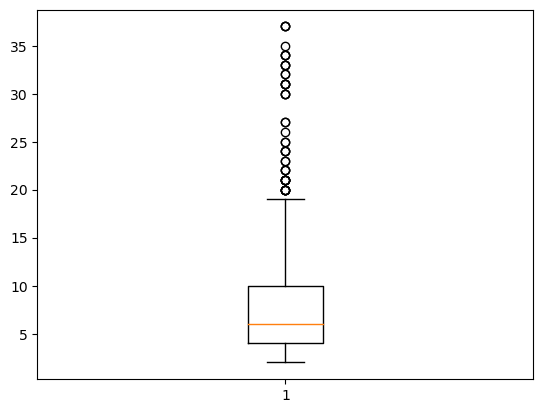

In [329]:
# Nb of clusters
plt.boxplot(compute_nb_clusters(clusters))
plt.show()

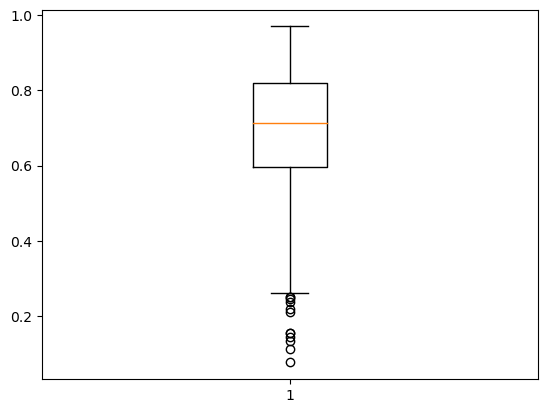

In [308]:
# Stability of the clusters
plt.boxplot(compute_rand_score(clusters))
plt.show()

## Markowitz

In [ ]:
def find_representatives(clusters):
    nb_clustering = len(clusters.keys())
    representatives = []
    for i in range(nb_clustering):
        
        current_representatives = []
        current_cluster = clusters[list(clusters.keys())[i]]

        # Loop through each community
        for group in range(max(current_cluster.values())):
            subset = [cluster[0] for cluster in current_cluster.items() if cluster[1] == group]
            # Subset the data for the current group
            subset_data = df[subset]

            # Apply PCA
            pca = PCA()
            principal_components = pca.fit_transform(subset_data)

            # Identify the leading coin (biggest contributor in the first principal component)
            leading_coin_index = np.argmax(np.abs(pca.components_[0]))
            leading_coin = subset_data.columns[leading_coin_index]
            current_representatives.append(leading_coin)
            # Print
        representatives.append(current_representatives)
    return representatives

In [ ]:
representatives = find_representatives(clusters)
representatives

In [ ]:
from collections import Counter
Counter([a for r in representatives for a in r]).most_common(100)

In [ ]:
len(representatives)